In [19]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


#these libraries will be used to generate indicators from the raw data
import ta.momentum as moment
import ta.volume as vol
import ta.volatility as vl
import ta.trend as trend

#packages for viewing TearsheetStatistics
from qstrader.statistics.tearsheet import TearsheetStatistics

#import 
#for backtesting
from __future__ import (absolute_import, division, print_function, unicode_literals)
import backtrader as bt
import datatime
import os.path
import sys

#import the different models that we will be using for selecting best performing models
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error #take root of this


#models
import xgboost.XGBRegressor as xgboost
from sklearn.linear_model import LinearRegression
from sklearn import svm

#note that for backtrader data feed must all be Yahoo Finance feed, otherwise custom data feed must be cretated

#Gridsearch will best time to do the train test split on
#Surivorship bias it not an issue because we only care about predicting the price of existing stocks, not stocks that do not exist anymore

#want to see all columns
pd.set_option('display.max_columns', None)


ModuleNotFoundError: No module named 'yfinance'

We are considering the entire universe of US stocks, but we would like to filter for good quality stocks based on domain knowledge
1. Filter for stocks above a certain marketcap (which alphavantage provides)
2. Filter for stocks that have a certain average volatility measure (will pick the measure and the minimum)

Other possibilities:
1. Only pick stocks that are in a given index (so as to limit the Universt of stocks considered at one time)



In [70]:
import seaborn as sns

<h2>Predefining Functions</h2>

In [12]:
def get_list_of_tickers():
    nyse_stocks_tickers = []
    nasdaq_stocks_tickers = []

    with open("nyse_stocks_list.txt", 'r') as nyse_file, open("nasdaq_stock_list.txt", 'r') as nasdaq_file:
        nyse_stocks_tickers = nyse_file.read().split("\n")
        nasdaq_stocks_tickers = nasdaq_file.read().split("\n")
    
    '''
    Step 2: Ticker string cleaning:
    # 1) Remove Securities. If tickers have a caret (^) then they are indices, not securities, meaning we cannot directly invest in it
    # 2) Nasdaq's convention (where we got the .txt list uses '/' wheras yfinance uses '-'. Eg AKO/A in .txt -> AKO-A in yfinance
    '''
    nyse_stocks_list = []
    nasdaq_stocks_list = []

    '''
    There are a couple types of tickers that we will not consider:
    Remove tickers with 
    
    '''
    for ticker in nyse_stocks_tickers:
        if '^' not in ticker:
            if '/' in ticker:
                ticker = ticker.replace('/', '-')
            nyse_stocks_list.append(ticker)

    for ticker in nasdaq_stocks_tickers:
        if '^' not in ticker:
            if '/' in ticker:
                ticker = ticker.replace('/', '-')
            nasdaq_stocks_list.append(ticker) 
            
    tickers_list = nyse_stocks_list
    tickers_list.extend(nasdaq_stocks_list)
    return tickers_list

def get_master_dataset(tickers_list=[]):
    """
    In order to iterate through the master dataset using tickers in the dataset, please do df.group_by(level=0)
    """
    
    
    if tickers_list.isempty():
        tickers_list = get_list_of_tickers()
        
    master_dataset = yf.download(
        tickers=tickers_list,
        period="15y",
        interval='1d',
        group_by='ticker',
        auto_adjust = True, # adjusts for splits and dividends, necessary for accuracy
        threads=True,
    )
    return master_dataset
    

        


<h2>Data Pulling</h2>

In [4]:
master_data = get_master_dataset()


['A',
 'AA',
 'AAC',
 'AAIC',
 'AAIC^B',
 'AAIC^C',
 'AAIN',
 'AAM^A',
 'AAM^B',
 'AAN',
 'AAP',
 'AAQC',
 'AAT',
 'AB',
 'ABB',
 'ABBV',
 'ABC',
 'ABEV',
 'ABG',
 'ABM',
 'ABR',
 'ABR^D',
 'ABR^E',
 'ABR^F',
 'ABT',
 'AC',
 'ACA',
 'ACAQ',
 'ACC',
 'ACCO',
 'ACDI',
 'ACEL',
 'ACH',
 'ACHR',
 'ACI',
 'ACII',
 'ACM',
 'ACN',
 'ACP',
 'ACP^A',
 'ACR',
 'ACR^C',
 'ACR^D',
 'ACRE',
 'ACRO',
 'ACV',
 'ADC',
 'ADC^A',
 'ADCT',
 'ADEX',
 'ADM',
 'ADNT',
 'ADS',
 'ADT',
 'ADX',
 'AEE',
 'AEFC',
 'AEG',
 'AEL',
 'AEL^A',
 'AEL^B',
 'AEM',
 'AENZ',
 'AEO',
 'AER',
 'AES',
 'AESC',
 'AEVA',
 'AFB',
 'AFG',
 'AFGB',
 'AFGC',
 'AFGD',
 'AFGE',
 'AFI',
 'AFL',
 'AFT',
 'AFTR',
 'AG',
 'AGAC',
 'AGCB',
 'AGCO',
 'AGD',
 'AGI',
 'AGL',
 'AGM',
 'AGM^C',
 'AGM^D',
 'AGM^E',
 'AGM^F',
 'AGM^G',
 'AGO',
 'AGR',
 'AGRO',
 'AGS',
 'AGTI',
 'AGX',
 'AHH',
 'AHH^A',
 'AHL^C',
 'AHL^D',
 'AHL^E',
 'AHT',
 'AHT^D',
 'AHT^F',
 'AHT^G',
 'AHT^H',
 'AHT^I',
 'AI',
 'AIC',
 'AIF',
 'AIG',
 'AIG^A',
 'AIN',
 'AIO',

In [40]:
master_data.columns.levels[0]

NameError: name 'master_data' is not defined

<h2>Data Exploration</h2>

In [41]:
master_data = yf.download(
        tickers=["AAPL", "GOOGL", "SNAP"],
        period="15y",
        interval='1d',
        group_by='ticker',
        auto_adjust = True, # adjusts for splits and dividends, necessary for accuracy
        threads=True,
    )

[*********************100%***********************]  3 of 3 completed


In [42]:
master_data.head()

GOOGL                                               SNAP  \
                  Open        High         Low       Close    Volume Open   
Date                                                                        
2007-02-20  234.469467  236.611618  232.587585  236.286285   8127065  NaN   
2007-02-21  235.155151  239.579575  234.104111  238.168167  11269919  NaN   
2007-02-22  239.584579  242.362366  237.432434  238.163162  11476312  NaN   
2007-02-23  238.113113  238.713715  234.134140  235.545547   7757435  NaN   
2007-02-26  236.651657  237.862869  232.107101  232.697693   7931860  NaN   

                                      AAPL                                \
           High Low Close Volume      Open      High       Low     Close   
Date                                                                       
2007-02-20  NaN NaN   NaN    NaN  2.588700  2.634878  2.573715  2.626927   
2007-02-21  NaN NaN   NaN    NaN  2.629373  2.736713  2.628761  2.727844   
2007-02-22  NaN NaN   NaN    NaN  2.776774  2.777080  2.707355  2.737325   
2007-02-23  NaN NaN   NaN    NaN  2.726622  2.762708  2.717141  2.723869   
2007-02-26  NaN NaN   NaN    NaN  2.747416  2.752310  2.679221  2.706743   

                        
                Volume  
Date                    
2007-02-20   617702400  
2007-02-21  1155313600  
2007-02-22   838224800  
2007-02-23   517893600  
2007-02-26   615848800

In [43]:
master_data.shape

(3779, 15)

In [44]:
master_data.isna()

GOOGL                               SNAP                       \
             Open   High    Low  Close Volume   Open   High    Low  Close   
Date                                                                        
2007-02-20  False  False  False  False  False   True   True   True   True   
2007-02-21  False  False  False  False  False   True   True   True   True   
2007-02-22  False  False  False  False  False   True   True   True   True   
2007-02-23  False  False  False  False  False   True   True   True   True   
2007-02-26  False  False  False  False  False   True   True   True   True   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2022-02-14  False  False  False  False  False  False  False  False  False   
2022-02-15  False  False  False  False  False  False  False  False  False   
2022-02-16  False  False  False  False  False  False  False  False  False   
2022-02-17  False  False  False  False  False  False  False  False  False   
2022-02-18  False  False  False  False  False  False  False  False  False   

                    AAPL                              
           Volume   Open   High    Low  Close Volume  
Date                                                  
2007-02-20   True  False  False  False  False  False  
2007-02-21   True  False  False  False  False  False  
2007-02-22   True  False  False  False  False  False  
2007-02-23   True  False  False  False  False  False  
2007-02-26   True  False  False  False  False  False  
...           ...    ...    ...    ...    ...    ...  
2022-02-14  False  False  False  False  False  False  
2022-02-15  False  False  False  False  False  False  
2022-02-16  False  False  False  False  False  False  
2022-02-17  False  False  False  False  False  False  
2022-02-18  False  False  False  False  False  False  

[3779 rows x 15 columns]

What years do all of our stock data start in?

In [74]:
from collections import defaultdict

<h2>Data Cleaning, Normalization, and Target Creation</h2>

In [46]:
#keep current methodology of filling missing values with previous value 
master_data.fillna(method="ffill", inplace=True)
#for values that are empty, this means that the stock did not exist yet. We will not fill with 0 as when
#getting windows to train on we might train on a window that is all 0s

In [ ]:
def get_data_sloan_method():
    pass


<h2>Data Normalization</h2>

In [47]:
#to do, not necessary to normalize just for fun

Index(['AAPL', 'GOOGL', 'SNAP'], dtype='object')

In [53]:
#for each ticker in the list, create a supervised problem and put the ticker in a dictionary
data_ind = {}
for ticker in master_data.columns.levels[0]:
    data = master_data[ticker].copy(deep=True) #avoids setting value on slice
    
    #remove all empty rows, as this means that the stock doesn't exist
    data.dropna(inplace=True)
    #turn into a supervised problem by creating multiple future periods
    data["y1"] = data["Close"].shift(periods=1)
    data["y2"] =data["Close"].shift(periods=2)
    data["y3"] =data["Close"].shift(periods=3)
    data["y4"] =data["Close"].shift(periods=4)
    data["y5"] =data["Close"].shift(periods=5)

    data_ind[ticker] = data'2020-06-01'

    
    

<h3>More Data Exploration</h3>

In [78]:
#put all the dates into an array and sort that array from least to greatest
date_range = [data_ind[ticker].index[0].year for ticker in data_ind]
date_range.sort()
min_date, max_date = date_range[0], date_range[-1]

date_range_dict = dict.fromkeys(date_range, 0)
for date in date_range_dict.keys():
    date_range_dict[date] += 1

<AxesSubplot:>

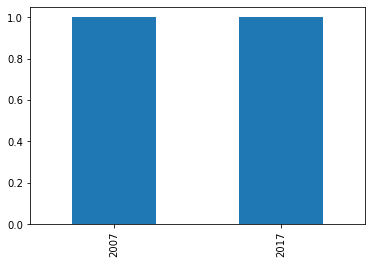

In [87]:
dates = pd.Series(date_range_dict)
dates.plot(kind='bar')

<h2>Training, Validation and Test Set Cretion</h2>

<h2>Baseline Models</h2>

In [60]:
#iterate through data, do baseline for each target
results_on_tergerts = {}
for ticker in data_ind.keys():
    data_ind[ticker] = 

dict_keys(['AAPL', 'GOOGL', 'SNAP'])

In [65]:
data_ind['GOOGL'].index[0].year

2007

In [71]:
tips = sns.load_dataset("tips")

In [72]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
